Database Source : [차량 외관 영상 데이터](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=554)

In [17]:
import torch
import cv2
import glob, os
import json
import pandas as pd

In [18]:
base_dataset_path = "dataset"

car_appearance_path = os.path.join(base_dataset_path, "car_appearance_origin")

dir2cls = {directory : i for i, directory in enumerate(glob.glob(car_appearance_path+"\*\*\*"))}
cls2dir = {i : directory for i, directory in enumerate(glob.glob(car_appearance_path+"\*\*\*"))}

In [19]:
dest_dataset_path = os.path.join(base_dataset_path, "car_appearance")
os.makedirs(dest_dataset_path, exist_ok=True)

In [20]:
columns = ["LargeCategoryId",
           'MediumCategoryId',
           'SmallCategoryId',
           'yearId',
           'colorId',
           'file_name',
           'directory',
           'classId',
           "viewpoint"]
annotation_df = pd.DataFrame(columns=columns)

In [21]:
def make_empty_row():
    
    return pd.Series(index=columns, dtype=str)

make_empty_row()

LargeCategoryId     NaN
MediumCategoryId    NaN
SmallCategoryId     NaN
yearId              NaN
colorId             NaN
file_name           NaN
directory           NaN
classId             NaN
viewpoint           NaN
dtype: object


## The part list of car

> P00.차량전체 <br>
> P01.프론트범퍼	  : 전방 <br>
> P02.리어범퍼        : 후방<br>
> P03.타이어(휠)<br>
> P04.A필러			<br> 
> P05.c필러<br>
> P06.사이드미러<br>
> P07.앞도어<br>
> P08.뒷도어<br>
> P09.라디에이터그릴<br>
> P10.헤드램프		: 전방<br>
> P11.리어램프		: 후방<br>
> P12.보닛<br>
> P13.트렁크<br>
> P14.루프<br>


In [ ]:
import numpy as np

rows = []

for dir, cls in dir2cls.items():
    for file in list(set(map(lambda x:x.split('.')[0], os.listdir(dir)))):
        with open(dir+"\\"+file+".json", encoding="utf-8") as f:
            json_object = json.load(f)
        
        row = make_empty_row()
        
        row['LargeCategoryId'] = json_object['rawDataInfo']['LargeCategoryId']
        row['MediumCategoryId'] = json_object['rawDataInfo']['MediumCategoryId']
        row['SmallCategoryId'] = json_object['rawDataInfo']['SmallCategoryId']
        row['yearId'] = json_object['rawDataInfo']['yearId']
        row['colorId'] = json_object['rawDataInfo']['colorId']
        row['file_name'] = file+".jpg"
        row['directory'] = dir
        
        try:
            anno = list(filter(lambda x: x['classId']=='P00.차량전체',
                            json_object['learningDataInfo']['objects']))[0]
            
            parts_list = list(
                map(lambda x: x['classId'], json_object['learningDataInfo']['objects']))
            
            
            front = True if ("P10.헤드램프" in parts_list) or ("P01.프론트범퍼" in parts_list) else False
            back = True if ("P11.리어램프" in parts_list) or ("P02.리어범퍼" in parts_list) else False
            
            if front and not back:
                row['viewpoint'] = "F"
            elif not front and back:
                row['viewpoint'] = "B"
            else:
                row['viewpoint'] = "S"
            
            # --------------------------------
            # uncomment for image Cropping
            # --------------------------------
            
            # file_path = os.path.join(dir, file+".jpg")
            # img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8),
            #                 cv2.IMREAD_UNCHANGED)
            # cropped_image = img[int(anno['coords']['tl']['y']):int(anno['coords']['br']['y']),
            #                     int(anno['coords']['tl']['x']):int(anno['coords']['br']['x'])]
            
            # cv2.imwrite(dest_dataset_path+"/"+file+".jpg", cropped_image)
            
            rows.append(row)
        except IndexError:
            pass


In [23]:
anno_df=pd.DataFrame(rows)

In [24]:
cat2cls = {}

anno_df['classId'] = -1

i = 0

cid = []
for idx, row in anno_df.iterrows():
    
    cat = row.iloc[0]+row.iloc[1]+row.iloc[2]+str(row.iloc[3])+row.iloc[4]
    
    if cat2cls.get(cat, -1) == -1:
        cat2cls[cat] = i
        i += 1
    
    cid.append(cat2cls[cat])
    
anno_df['classId'] = pd.Series(cid)

In [25]:
anno_df.groupby("viewpoint").count()

,LargeCategoryId,MediumCategoryId,SmallCategoryId,yearId,colorId,file_name,directory,classId
viewpoint,,,,,,,,
B,2848,2848,2848,2848,2848,2848,2848,2848
F,2465,2465,2465,2465,2465,2465,2465,2465
S,5802,5802,5802,5802,5802,5802,5802,5802


In [26]:
anno_df.to_csv(dest_dataset_path+'/'+"annotation.csv", index=False)


# Front? Side? Back?

In [27]:
import pandas as pd
dest_dataset_path = os.path.join('dataset', "car_appearance")
anno_df = pd.read_csv(dest_dataset_path+"/annotation.csv")

In [28]:
import matplotlib.pyplot as plt

samples = anno_df.groupby("viewpoint").sample(10)

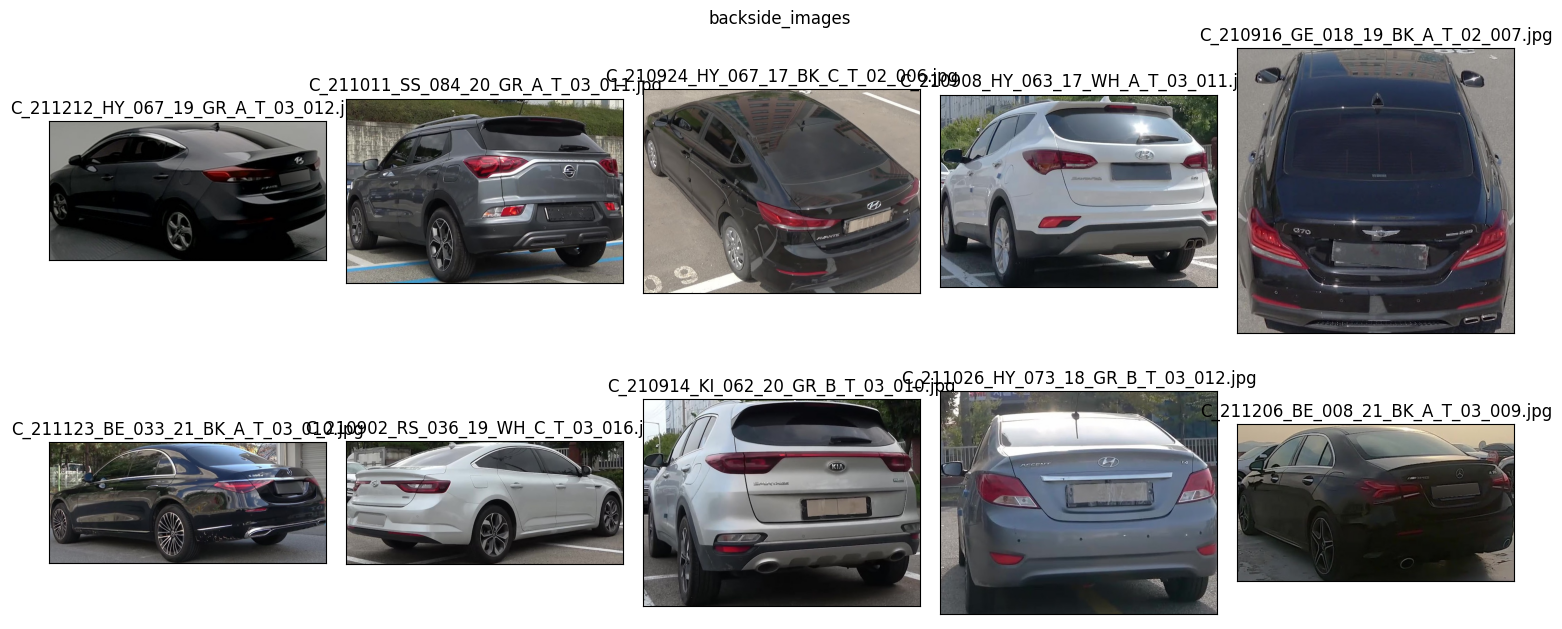

In [30]:
from util.visualize import show_sample_images

show_sample_images(samples.iloc[:10], dest_dataset_path, "backside_images")

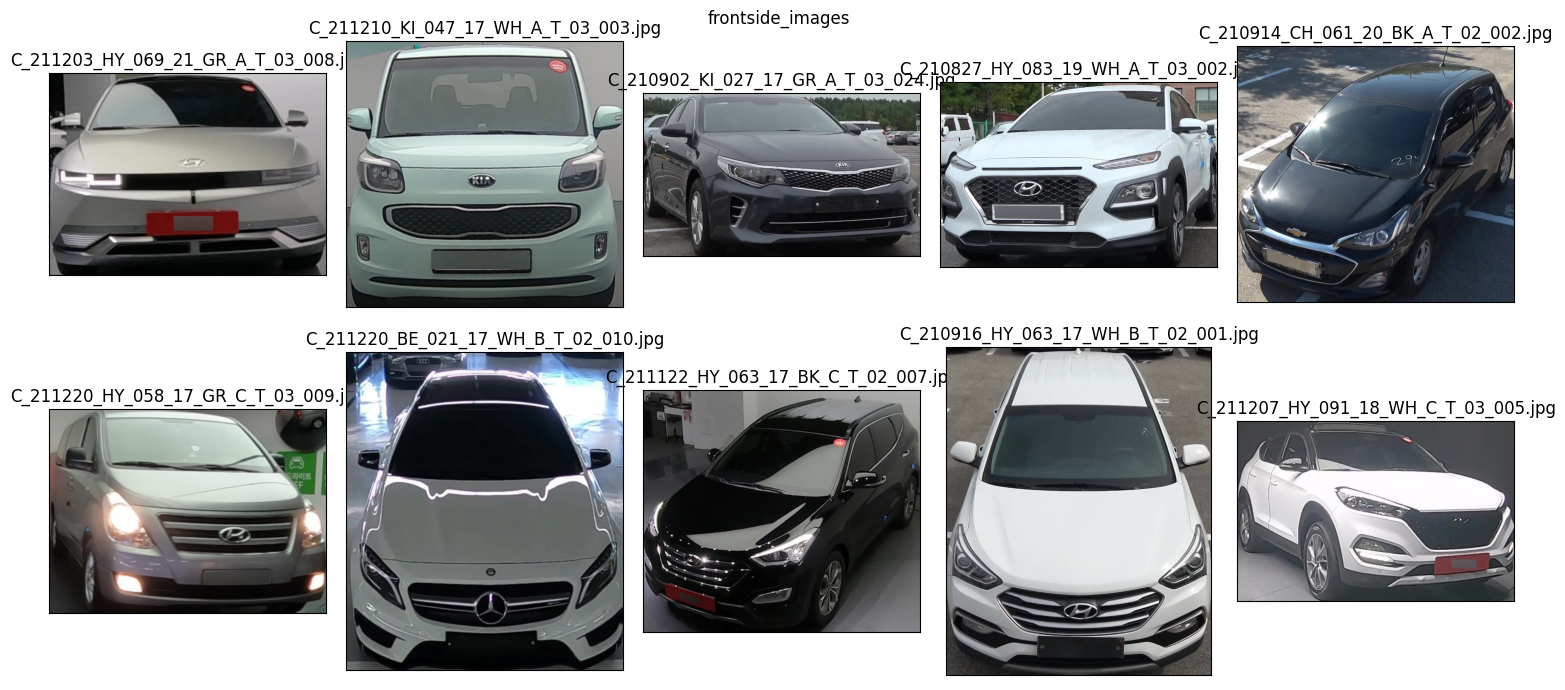

In [31]:
from util.visualize import show_sample_images

show_sample_images(samples.iloc[10:20], dest_dataset_path, "frontside_images")


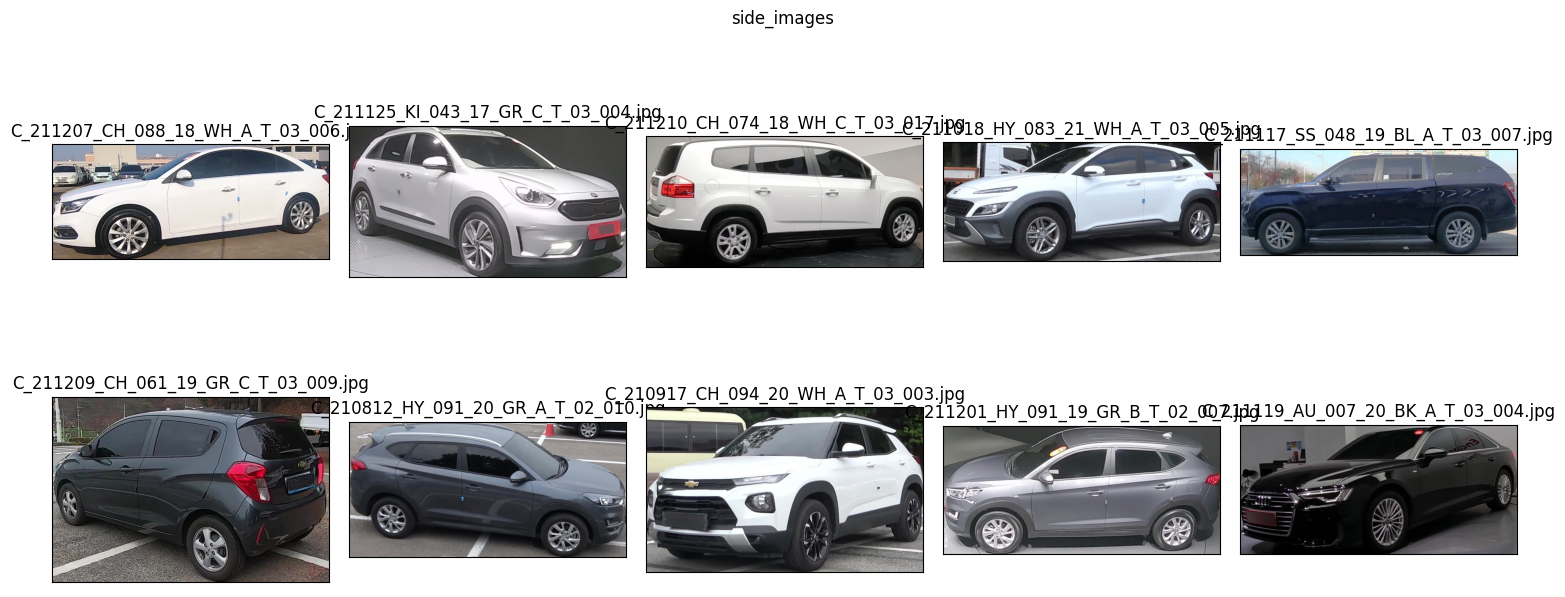

In [32]:
show_sample_images(samples.iloc[20:], dest_dataset_path, "side_images")


In [47]:
def verify(df, message):
    """
    Check if row's order is sorted
    
    Keyword arguments:
    argument -- description
    df : pd.DataFrame -- base DataFrame
    message : str -- the string what would be checked
    """
    
    df_ = df.groupby("classId").apply(
        lambda group: group if len(group) > 1 else None
    ).reset_index(drop=True)
    queries = df_.groupby("classId").first()
    gallaries = df_.groupby("classId").apply(
        lambda group: group.iloc[1:]
    ).reset_index(drop=True)
    assert sum(queries.index == sorted(queries.index)) == len(queries), "queries are not ordered"
    assert sum(gallaries.groupby("classId").agg(pd.DataFrame.sample).index == sorted(queries.index)) == len(queries), "gallaries samples are not ordered"
    print(message + " Verified")

verify(anno_df.sample(frac=1).reset_index(drop=True), "Shuffle")
verify(anno_df[anno_df.viewpoint=="F"], "groupping")


Shuffle Verified
groupping Verified


In [53]:
df = anno_df.groupby("classId").apply(
    lambda group : group if len(group) > 1 else None
).reset_index(drop=True)

df.groupby("classId").sample(1, random_state=42)

,LargeCategoryId,MediumCategoryId,SmallCategoryId,yearId,colorId,file_name,directory,classId,viewpoint
11,중형차,아우디,A4,2017,검정,C_211223_AU_006_17_BK_B_T_03_005.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,0,B
13,중형차,아우디,A4,2017,회색,C_211220_AU_006_17_GR_B_T_02_002.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,1,F
22,중형차,아우디,A4,2017,흰색,C_211222_AU_006_17_WH_A_T_02_010.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,2,S
27,중형차,아우디,A4,2018,회색,C_211126_AU_006_18_GR_A_T_03_018.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,3,B
32,중형차,아우디,A4,2018,흰색,C_211222_AU_006_18_WH_A_T_03_014.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,4,B
...,...,...,...,...,...,...,...,...,...
11060,대형차,볼보,S90,2019,검정,C_211123_VV_001_19_BK_A_T_03_019.jpg,dataset\car_appearance_origin\VV_볼보\001_S90\20...,1032,S
11065,중형차,볼보,XC60,2017,빨강,C_211223_VV_095_17_RE_A_T_02_005.jpg,dataset\car_appearance_origin\VV_볼보\095_XC60\2...,1033,S
11071,중형차,볼보,XC60,2017,흰색,C_211222_VV_095_17_WH_C_T_03_014.jpg,dataset\car_appearance_origin\VV_볼보\095_XC60\2...,1034,F
11078,중형차,볼보,XC60,2018,검정,C_211213_VV_095_18_BK_A_T_03_018.jpg,dataset\car_appearance_origin\VV_볼보\095_XC60\2...,1035,S


In [54]:
df.groupby("classId").first()

,LargeCategoryId,MediumCategoryId,SmallCategoryId,yearId,colorId,file_name,directory,viewpoint
classId,,,,,,,,
0,중형차,아우디,A4,2017,검정,C_211222_AU_006_17_BK_A_T_03_024.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,S
1,중형차,아우디,A4,2017,회색,C_211220_AU_006_17_GR_B_T_02_002.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,F
2,중형차,아우디,A4,2017,흰색,C_211222_AU_006_17_WH_A_T_02_010.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,S
3,중형차,아우디,A4,2018,회색,C_211126_AU_006_18_GR_A_T_03_020.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,B
4,중형차,아우디,A4,2018,흰색,C_211222_AU_006_18_WH_A_T_02_001.jpg,dataset\car_appearance_origin\AU_아우디\006_A4\20...,S
...,...,...,...,...,...,...,...,...
1032,대형차,볼보,S90,2019,검정,C_211123_VV_001_19_BK_A_T_03_010.jpg,dataset\car_appearance_origin\VV_볼보\001_S90\20...,B
1033,중형차,볼보,XC60,2017,빨강,C_211223_VV_095_17_RE_A_T_02_001.jpg,dataset\car_appearance_origin\VV_볼보\095_XC60\2...,S
1034,중형차,볼보,XC60,2017,흰색,C_211217_VV_095_17_WH_B_T_03_015.jpg,dataset\car_appearance_origin\VV_볼보\095_XC60\2...,S
